# New Section

In [ ]:


import asyncio
import os
import sys
import aiohttp
import pandas as pd
from typing import List, Dict, Any

API_KEY = os.getenv("NYT_API_KEY", "PQepQBSs9AQPcHmyAPEGZ70JsZZyyi1W")

YEARS = [
    2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
    2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
]


async def fetch_month_data(
    session: aiohttp.ClientSession, year: int, month: int, max_retries: int = 3
) -> List[Dict[str, Any]]:
    """
    Asynchronously fetches and processes article data for a single month,
    with a retry mechanism for rate limiting.
    """
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={API_KEY}"

    for attempt in range(max_retries):
        print(f"Fetching data for {year}-{month:02d} (Attempt {attempt + 1})...")
        try:
            async with session.get(url) as response:
                response.raise_for_status()

                if "application/json" not in response.headers.get("Content-Type", ""):
                    print(f"  > Warning: Non-JSON response for {year}-{month:02d}. Skipping.")
                    return []

                data = await response.json()
                docs = data.get("response", {}).get("docs", [])

                print(f"  > Found {len(docs)} documents for {year}-{month:02d}.")

                monthly_articles = []
                for article in docs:
                    if article.get("document_type") == "article" and article.get("headline", {}).get("main"):
                        keywords = [kw.get("value") for kw in article.get("keywords", []) if "value" in kw]
                        monthly_articles.append({
                            "year": year,
                            "month": month,
                            "headline": article["headline"]["main"],
                            "lead_paragraph": article.get("lead_paragraph", "N/A"),
                            "news_desk": article.get("news_desk", "N/A"),
                            "keywords": ", ".join(keywords),
                        })

                print(f"  > Processed and added {len(monthly_articles)} articles.")
                return monthly_articles # Success!

        except aiohttp.ClientError as e:
            if e.status == 429:
                if attempt < max_retries - 1:
                    wait_time = (2 ** attempt) * 6
                    print(f"  > Rate limit hit for {year}-{month:02d}. Retrying in {wait_time} seconds...")
                    await asyncio.sleep(wait_time)
                    continue
                else:
                    # This is the final failure for a 429 error
                    print(f"\n  >>> CRITICAL: Repeated '429 Too Many Requests' error.")
                    print(f"  >>> This often indicates an INVALID or EXPIRED API KEY.")
                    print(f"  >>> Please verify your key at the NYT Developer Portal.\n")
                    return []
            else:
                print(f"  >>> HTTP error for {year}-{month:02d}: {e}")
                return []
        except asyncio.TimeoutError:
            print(f"  >>> Request timed out for {year}-{month:02d}.")
            return []
        except Exception as e:
            print(f"  >>> An unexpected error occurred for {year}-{month:02d}: {e}")
            return []

    print(f"  >>> Failed to fetch data for {year}-{month:02d} after {max_retries} attempts.")
    return []

# --- Main Orchestration Function ---

async def main() -> pd.DataFrame:
    """
    Main function to orchestrate the fetching of all data and return a DataFrame.
    """
    # --- CRITICAL API KEY CHECK ---
    if not API_KEY or API_KEY == "YOUR_API_KEY_HERE":
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! ERROR: NYT_API_KEY is not set.")
        print("!!! Please replace 'YOUR_API_KEY_HERE' with your actual key,")
        print("!!! or set it as an environment variable.")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        # In a standalone script, we would exit. Here, we return an empty DataFrame.
        return pd.DataFrame()

    print(f"--- Using API Key ending in: '...{API_KEY[-4:]}' ---")

    all_articles = []

    timeout = aiohttp.ClientTimeout(total=60)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [
            fetch_month_data(session, year, month)
            for year in YEARS
            for month in range(1, 13)
        ]

        # Process tasks one by one to avoid sending a burst of requests.
        # The NYT API limit is 5 requests per minute. Waiting 13 seconds
        # between requests gives a safe buffer.
        for i, task in enumerate(tasks):
            month_result = await task
            if month_result:
                all_articles.extend(month_result)

            if i < len(tasks) - 1:
                print("--- Waiting 13 seconds before next request ---")
                await asyncio.sleep(12)

    print(f"\nFinished fetching data! Found a total of {len(all_articles)} articles.")

    if not all_articles:
        return pd.DataFrame()

    return pd.DataFrame(all_articles)

# --- Execution Block ---

print("Starting article fetching process...")
my_dataframe = await main()

print("\n--- Final DataFrame Info ---")
if not my_dataframe.empty:
    print(my_dataframe.head())
    print("\nDataFrame Info:")
    my_dataframe.info()
else:
    print("The final DataFrame is empty.")



Starting article fetching process...
--- Using API Key ending in: '...yi1W' ---
Fetching data for 2004-01 (Attempt 1)...
  > Found 8810 documents for 2004-01.
  > Processed and added 8728 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-02 (Attempt 1)...
  > Found 8750 documents for 2004-02.
  > Processed and added 8657 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-03 (Attempt 1)...
  > Found 8986 documents for 2004-03.
  > Processed and added 8892 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-04 (Attempt 1)...
  > Found 8519 documents for 2004-04.
  > Processed and added 8428 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-05 (Attempt 1)...
  > Found 8899 documents for 2004-05.
  > Processed and added 8812 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-06 (Attempt 1)...
  > Found 8436 documents for 2004-06.
  > Processed an

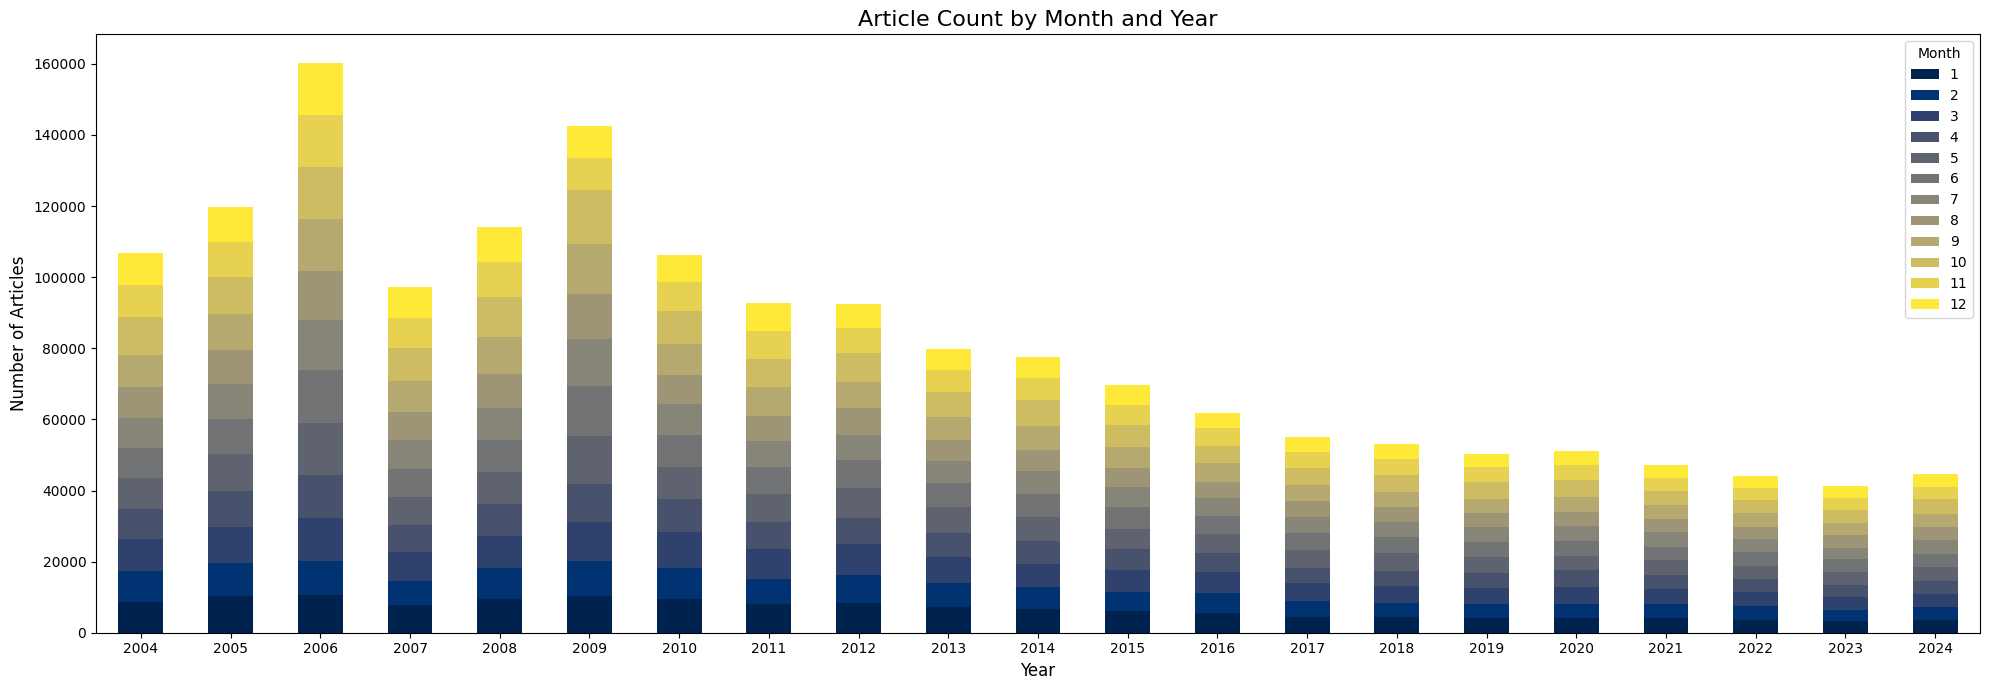

In [ ]:
import matplotlib.pyplot as plt
article_counts = my_dataframe.groupby(['year', 'month']).size().reset_index(name='article_count')
plot_data = article_counts.pivot(index='year', columns='month', values='article_count')

plot_data.fillna(0, inplace=True)

plot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 7),
    colormap='cividis'
)

plt.title('Article Count by Month and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Month')
plt.tight_layout()
plt.show()

In [ ]:
my_dataframe.head()

,year,month,headline,lead_paragraph,news_desk,keywords
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr..."
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man..."
3,2004,1,"Paid Notice: Deaths PAONE, NICOLA","PAONE--Nicola. On December 25, 2003 at age 88....",Classified,"PAONE, NICOLA"
4,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV..."


In [ ]:
output_filename = "nyt_articles_04-24_final.csv"
my_dataframe.to_csv(output_filename, index=False)
